*Export Controlled: ECCN EAR1E998*

Warning:  This document contains technical data whose export is restricted by the Bureau of Industry & Security’s Export Administration Regulations and cannot be exported or re-exported without the authorization of the U.S. government.   Violations of these export laws are subject to severe criminal penalties.  Diversion contrary to U.S. law is prohibited.

# Develop anomaly detection algorithm for HVAC time series data

Start with:

* supply fan power of some AHU, time series data of one year
* labels (manual labeled with domain knowledge)

Objective:

* classification algorithm to automatically monitor SF status

## Step 1: Import DAL functions

We've also created a namespace (aliases) to include frequently used libraries such as `pandas`, `sklearn`.

Here, we'll be using 3 classification algorithms:

* Support vector machine
* K nearest neighbors
* Random forest

In [1]:
from UTCDAL.Design.TimeseriesAnalysis import generate_features
from UTCDAL.Utilities.DataAccess.getdata_wc import get_trend

C:\Users\chenqian\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
from UTCDAL.Externals import *
from UTCDAL.Externals.Classification import *
from UTCDAL.Externals.MLUtilities import *
    
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn')

## Step 2: Read one year data from webctrl, exploration and visualization

Reading data from webctrl is only one line.

In [ ]:
GQL = '#utrc_l_meter_13/real_pwr_tn'  # AHU36 SF
df = get_trend(GQL, '2016-5-1', 365)

In [3]:
#ignore
df = pd.read_csv('sf_ahu_raw_36.csv', index_col=0, infer_datetime_format=True, parse_dates=True)

Take a quick look at the data.

In [4]:
df.head()

,values
2016-05-01 00:00:00,0.000375
2016-05-01 00:01:00,0.000369
2016-05-01 00:02:00,0.000655
2016-05-01 00:03:00,0.001391
2016-05-01 00:04:00,0.001001


Visualize:

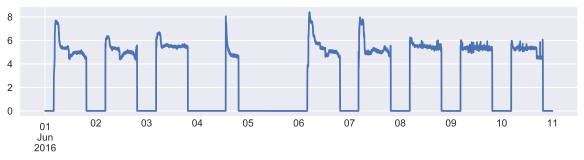

In [5]:
df['2016-6-1': '2016-6-10'].plot(figsize=(10, 2), legend=False)

In [6]:
labels = pd.read_csv('AHU36_SF_Power_label.csv')
labels.head(3)

,label
0,daytime on
1,Normal
2,Normal


Get some statistics about the label:

In [7]:
labels.label.value_counts()

Normal              223
daytime on          106
day spike            15
night on             10
morning on            5
wholeday on           4
short operations      1
Name: label, dtype: int64

## Step 3: Generate time series features for each day

* Statistical features: mean, max, median, etc.
* Trend features: slope, #peaks, etc.

**Future: interface for adding features by domain knowledge**

In [ ]:
features = generate_features(df)

In [8]:
#ignore
# with open('ahu36_features.pkl', 'wb') as f:
#     pickle.dump(features, f)

with open('ahu36_features.pkl', 'rb') as f:
    features = pickle.load(f)

In [9]:
features.shape

(364, 794)

# Step 4: Preprocessing: scale & feature selection

In [10]:
y = labels.label.values

In [11]:
scaler = StandardScaler()
scaler.fit(features.values)
X_scaled = scaler.transform(features.values)

selector = SelectKBest(k=300)
selector.fit(X_scaled, y)

X = selector.transform(X_scaled)

C:\Users\chenqian\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 81  82  83  84  87  88  89  93  94  99 106 107 108 109 112 113 114 118
 119 124 131 132 133 134 137 138 139 143 144 149 156 157 158 159 162 163
 164 168 169 174 259 260 676 697 713 723 747 764 787 789 790 791] are constant.
  UserWarning)
C:\Users\chenqian\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [12]:
def save_pickle(obj, fname):
    with open(fname, 'wb') as f:
        pickle.dump(obj, f)

In [13]:
save_pickle(scaler, 'model_scaler.pkl')
save_pickle(selector, 'model_selector.pkl')

# Step 5: Train model: tune optimal parameters

In [14]:
clf = SVC(C=1)
cross_val = cross_val_score(clf, X, y, cv=4)
print(f'Cross-validation score: {cross_val}\nCross-validation mean score: {cross_val.mean():.5f}')

C:\Users\chenqian\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)


Cross-validation score: [ 0.77659574  0.72826087  0.96666667  0.96590909]
Cross-validation mean score: 0.85936


Continue the trial-and-error process; find relatively good parameters

In [15]:
clf_svm = SVC()
clf_svm.fit(selector.fit_transform(X_scaled, y), y)

clf_knn = KNeighborsClassifier(n_neighbors=5)
clf_knn.fit(selector.fit_transform(X_scaled, y), y)

clf_rf = RandomForestClassifier(n_estimators=300)
clf_rf.fit(selector.fit_transform(X_scaled, y), y);

C:\Users\chenqian\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 81  82  83  84  87  88  89  93  94  99 106 107 108 109 112 113 114 118
 119 124 131 132 133 134 137 138 139 143 144 149 156 157 158 159 162 163
 164 168 169 174 259 260 676 697 713 723 747 764 787 789 790 791] are constant.
  UserWarning)
C:\Users\chenqian\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


## Step 6: Save the trained model for deploy

In [16]:
save_pickle(clf_svm, 'model_svm.pkl')
save_pickle(clf_knn, 'model_knn.pkl')
save_pickle(clf_rf, 'model_rf.pkl')

## For server side, need another .py file to apply model to latest data and visualize result

This logic was saved into a `.py` file.